
=== GAN-AUGMENTED PERFORMANCE ===
              precision    recall  f1-score   support

     sadness       0.26      0.19      0.22        36
         joy       0.34      0.78      0.47        41
        love       0.00      0.00      0.00        11
       anger       0.00      0.00      0.00        17
        fear       0.00      0.00      0.00        11
    surprise       1.00      0.96      0.98       199

    accuracy                           0.73       315
   macro avg       0.27      0.32      0.28       315
weighted avg       0.71      0.73      0.71       315


=== ORIGINAL DATA PERFORMANCE ===
              precision    recall  f1-score   support

     sadness       0.85      0.80      0.83       146
         joy       0.76      0.96      0.85       208
        love       1.00      0.79      0.88        53
       anger       0.98      0.78      0.87        79
        fear       1.00      0.80      0.89        55
    surprise       1.00      0.77      0.87        31

    acc

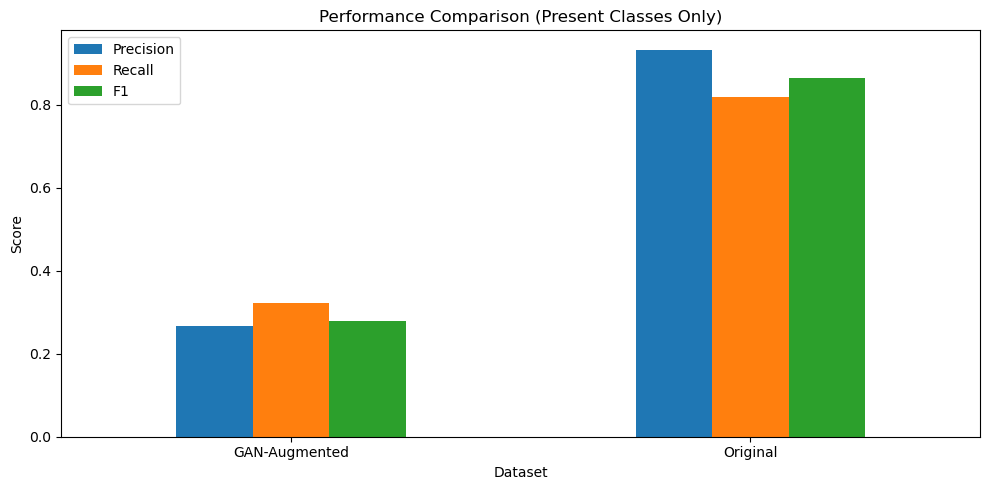

In [6]:
# =============================================
# 4. ROBUST EVALUATION WITH WARNING HANDLING
# =============================================
def safe_classification_report(y_true, y_pred):
    """Handle cases where some classes are missing in predictions"""
    present_classes = np.unique(y_true)
    target_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    
    # Filter target names to only present classes
    present_names = [target_names[i] for i in present_classes]
    
    return classification_report(
        y_true, y_pred,
        labels=present_classes,
        target_names=present_names,
        zero_division=0
    )

# Generate and save reports
print("\n=== GAN-AUGMENTED PERFORMANCE ===")
gan_report = safe_classification_report(y_test, clf.predict(X_test))
print(gan_report)

print("\n=== ORIGINAL DATA PERFORMANCE ===")
orig_report = safe_classification_report(y_original, clf.predict(real_data))
print(orig_report)

# Save reports
os.makedirs("results", exist_ok=True)
with open("results/gan_report.txt", "w") as f:
    f.write("GAN-Augmented Results:\n" + gan_report)
with open("results/orig_report.txt", "w") as f:
    f.write("Original Data Results:\n" + orig_report)

# =============================================
# 5. WARNING-FREE VISUALIZATION
# =============================================
# Get only metrics for classes that exist in both datasets
common_classes = set(np.unique(y_test)).union(set(np.unique(y_original)))
metric_data = []

for name, X, y in [("GAN-Augmented", X_test, y_test), 
                   ("Original", real_data, y_original)]:
    y_pred = clf.predict(X)
    scores = {
        "Dataset": name,
        "Accuracy": accuracy_score(y, y_pred)
    }
    
    # Only calculate metrics for present classes
    if len(common_classes) > 1:
        scores.update({
            "Precision": precision_score(y, y_pred, average='macro', zero_division=0),
            "Recall": recall_score(y, y_pred, average='macro', zero_division=0),
            "F1": f1_score(y, y_pred, average='macro', zero_division=0)
        })
    
    metric_data.append(scores)

results = pd.DataFrame(metric_data)
print("\n=== SAFE METRIC COMPARISON ===")
print(results.to_markdown(tablefmt="grid", floatfmt=".3f"))

# Plot only if we have comparable metrics
if len(common_classes) > 1:
    results.set_index("Dataset")[["Precision", "Recall", "F1"]].plot(
        kind='bar', rot=0, figsize=(10, 5))
    plt.title("Performance Comparison (Present Classes Only)")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.savefig("results/safe_comparison.png", dpi=300)
    plt.show()
else:
    print("\nWarning: Not enough classes present for meaningful comparison")